In [5]:
import pandas as pd
import numpy as np
import datetime as dt


import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import joblib

import plotly.express as px
import plotly.graph_objs as go


%matplotlib inline

In [6]:
df = pd.read_csv('Data/cleaned_sales_data2')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1039557,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
1039558,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1039559,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1039560,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Invoice,1039562.0,537647.459037,26660.149945,489434.0,515339.00,537641.00,561036.00,581587.00
StockCode,1039562.0,33662.998902,23474.766215,10002.0,21791.00,22469.00,23307.00,90214.00
Quantity,1039562.0,11.201933,129.709885,1.0,1.00,3.00,11.00,80995.00
Price,1039562.0,3.330564,4.732068,0.0,1.25,2.10,4.13,1157.15
Customer ID,802693.0,15338.078239,1693.934876,12346.0,13988.00,15276.00,16809.00,18287.00
Revenue,1039562.0,19.343719,196.785914,0.0,3.90,9.95,17.70,168469.60


In [8]:
daily_sales = df.groupby(pd.Grouper(key='InvoiceDate', freq='4D')).sum()                     #grouping sales based on a 4 day period. 
daily_sales.drop(columns = ['Invoice', 'StockCode', 'Customer ID'], axis = 1, inplace = True) #Dropping irrelevant rows. 
daily_sales.head()

,Quantity,Price,Revenue
InvoiceDate,,,
2009-12-01,130616,42881.61,227234.82
2009-12-05,61427,26391.04,126105.22
2009-12-09,63505,22687.39,121229.81
2009-12-13,110075,42039.03,191887.67
2009-12-17,39350,16793.56,82756.46


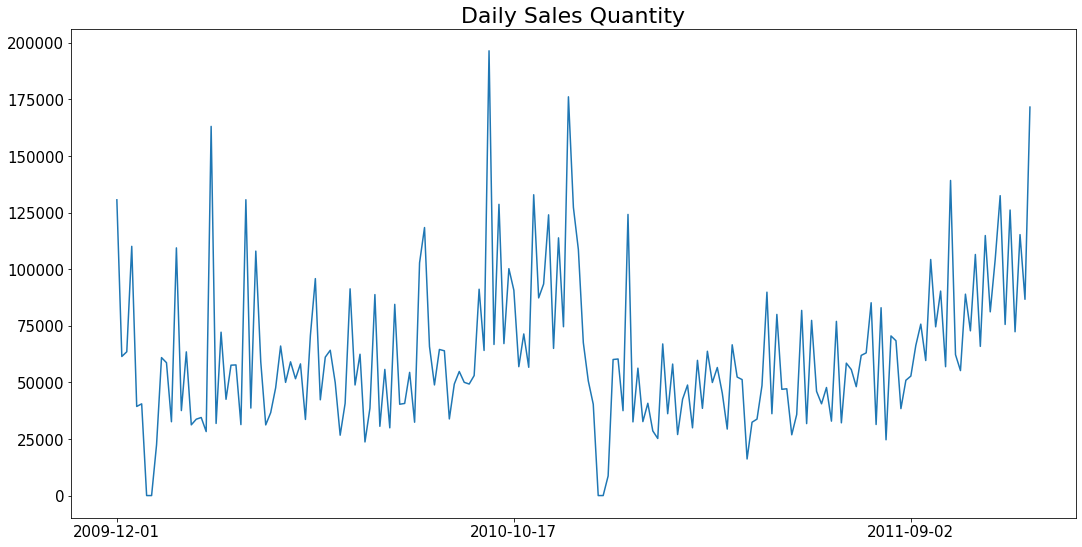

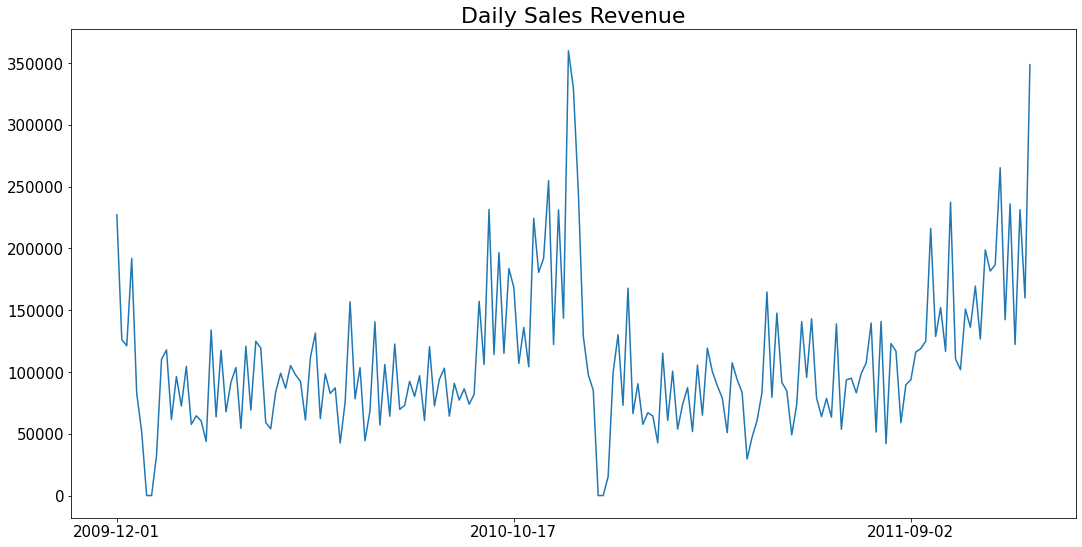

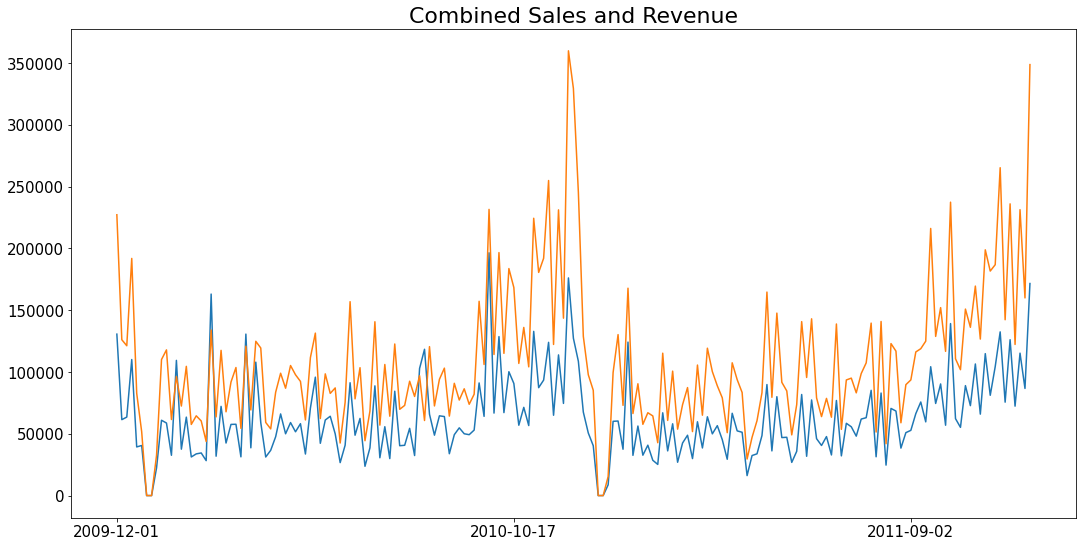

In [9]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    plt.figure(figsize=(18,9))
    for col in cols:
        plt.plot(df[col])
        
    plt.title(title, fontsize=22)
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=1)
    plt.yticks(fontsize=15)
    plt.xticks(df.index[0::steps], fontsize=15);

plot_series(daily_sales,['Quantity'], title = 'Daily Sales Quantity', steps = 80)
plot_series(daily_sales,['Revenue'], title = 'Daily Sales Revenue', steps = 80)
plot_series(daily_sales,['Quantity', 'Revenue'], title = 'Combined Sales and Revenue', steps = 80)

We can see from the graph that there are days were no sales are made, espcially during the December/January holidays. Given that this is primarily a B2B business, it is unsurprising that customers are not placing orders during holidays. 

In [10]:
daily_sales.loc[daily_sales['Quantity'] == 0]


,Quantity,Price,Revenue
InvoiceDate,,,
2009-12-25,0,0.0,0.0
2009-12-29,0,0.0,0.0
2010-12-24,0,0.0,0.0
2010-12-28,0,0.0,0.0


We can clearly see elements of seasonality in both the sales revenue and quanities sold. Beginning with back-to-school in September, until the new year, sales significantly increase. 

First step in determining stationarity beyond plotting the data is looking at the decomposition graphs for insight. 

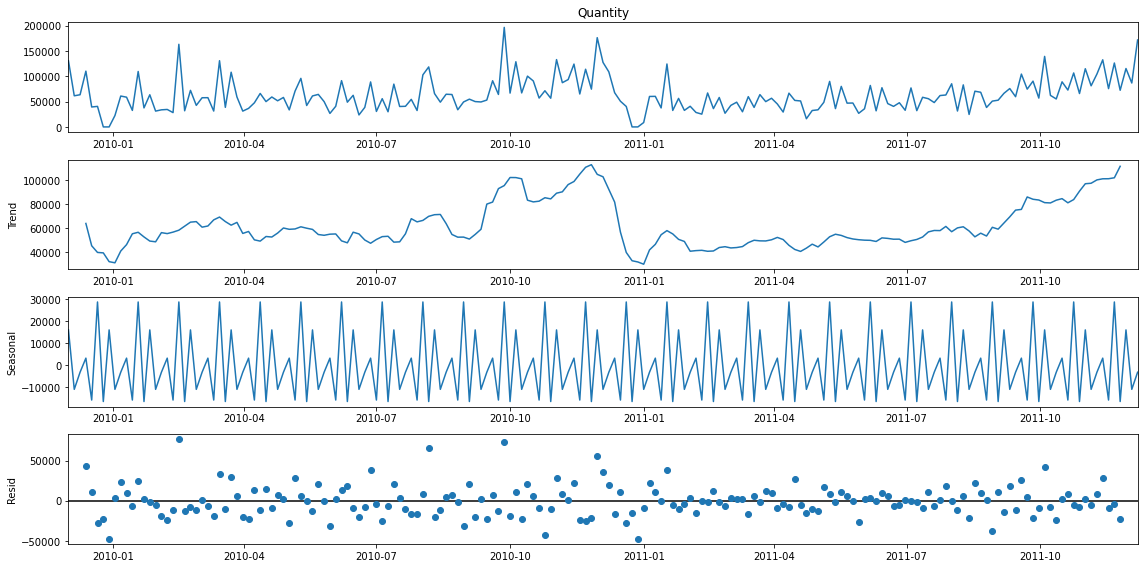

In [11]:
plt.rc("figure", figsize=(16,8))
decomp = seasonal_decompose(daily_sales['Quantity'])
decomp.plot();

There is no clear trend in the data, but obvious seasonality. There also appears to be significant noise in the data. 

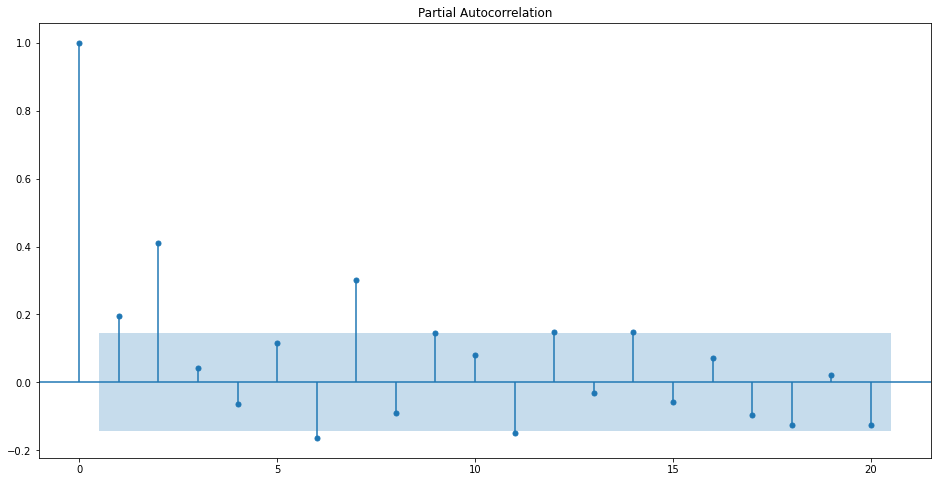

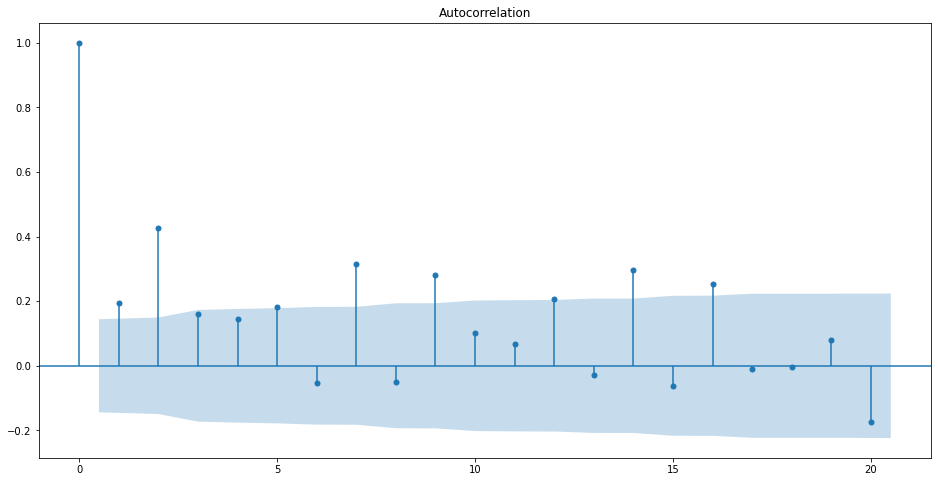

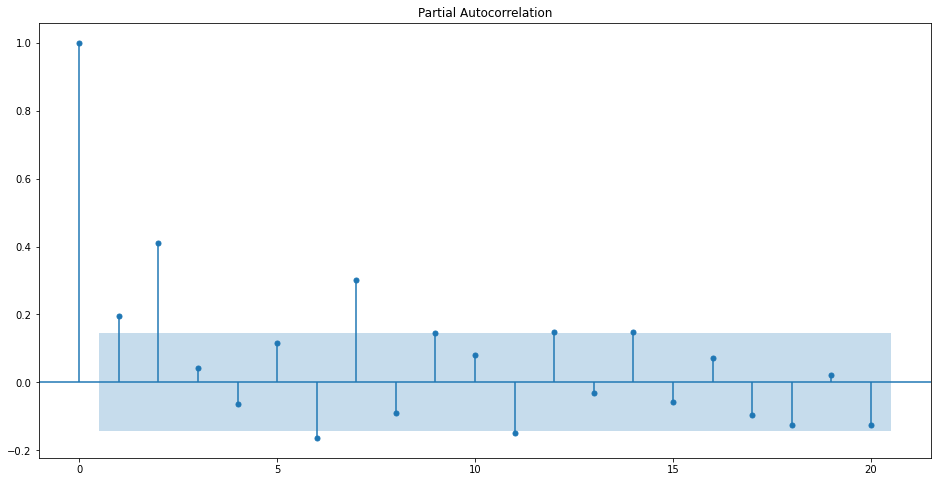

In [12]:
# The Autocorrelation plot also indicates that there is seasonality in the data. 
#We will want to use higher-order lags in our model.
#lt.rc("figure", figsize=(8,6))

plot_acf(daily_sales['Quantity'], lags = 20)
plot_pacf(daily_sales['Quantity'], lags = 20)


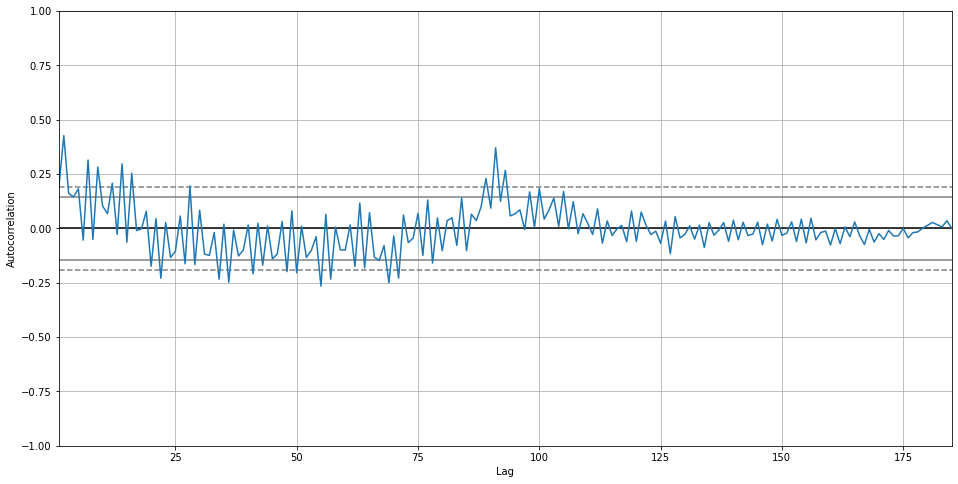

In [13]:
autocorrelation_plot(daily_sales['Quantity']); 

### Statistically Testing for Stationarity

We will perform the Augmented Dickey-Fuller test to determine if the Quantity and revenue features are stationary.

In [14]:
def interpret_adfuller(feature):
    result = adfuller(feature)
    print('Augmented Dickey-Fuller Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


In [15]:
interpret_adfuller(daily_sales['Quantity'])

#This p-value is much too high. Below we will take the first order difference. 

Augmented Dickey-Fuller Statistic: -1.277850
p-value: 0.639244
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


In [16]:
#This is an acceptible p-value.
interpret_adfuller(daily_sales['Quantity'].diff(1).dropna())

Augmented Dickey-Fuller Statistic: -6.038130
p-value: 0.000000
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


In [17]:
#Similar for Revenue. This is not surprising as revenue is partially a function of quantity

interpret_adfuller(daily_sales['Revenue'])

Augmented Dickey-Fuller Statistic: -1.226260
p-value: 0.662199
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


In [19]:
interpret_adfuller(daily_sales['Revenue'].diff().dropna())

Augmented Dickey-Fuller Statistic: -4.309367
p-value: 0.000428
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


In [20]:
#Adding the differential to the dataframe 
daily_sales['first_diff_quantity'] = daily_sales['Quantity'].diff(1)
daily_sales['first_diff_revenue'] = daily_sales['Revenue'].diff(1)
daily_sales

,Quantity,Price,Revenue,first_diff_quantity,first_diff_revenue
InvoiceDate,,,,,
2009-12-01,130616,42881.61,227234.82,NaN,NaN
2009-12-05,61427,26391.04,126105.22,-69189.0,-101129.60
2009-12-09,63505,22687.39,121229.81,2078.0,-4875.41
2009-12-13,110075,42039.03,191887.67,46570.0,70657.86
2009-12-17,39350,16793.56,82756.46,-70725.0,-109131.21
...,...,...,...,...,...
2011-11-21,126109,43521.76,236043.67,50532.0,93754.20
2011-11-25,72344,28027.97,122275.54,-53765.0,-113768.13
2011-11-29,115243,43847.08,231334.25,42899.0,109058.71


In [21]:
#Establishing the train-test split for the first order difference of quanitity and revenue. 

model_data = daily_sales[['first_diff_revenue', 'first_diff_quantity']]
model_data.dropna(inplace = True)
train, test = train_test_split(model_data, test_size = 0.085, shuffle = False)

<ipython-input-21-7f331f4f6048>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.dropna(inplace = True)


In [22]:
model = VAR(train)
ts_model = model.fit(maxlags=13, ic = 'aic' )
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Mar, 2021
Time:                     13:38:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    41.1700
Nobs:                     162.000    HQIC:                   40.8757
Log likelihood:          -3728.37    FPE:                4.62373e+17
AIC:                      40.6745    Det(Omega_mle):     3.96229e+17
--------------------------------------------------------------------
Results for equation first_diff_revenue
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                       1497.817769      3254.447238            0.460           0.645
L1.first_diff_revenue         -0.391513         0.144793           -2.704           0.007
L1.first_di

In [187]:
#Savinf our model to make future predictions in the web-app dashboard. 

joblib.dump(ts_model, "VAR-time-series-model-4D-interval")


['VAR-time-series-model-4D-interval']

In [26]:
def plot_results(x_test, x_train, y_testing, y_training, predictions, title):
    plt.figure(figsize=(20,10))
    plt.plot(x_train, y_training, color = 'blue')
    plt.plot(x_test, y_testing, color = 'orange')
    plt.plot(x_test, predictions, color = 'green')
    plt.title(label = title, fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20);


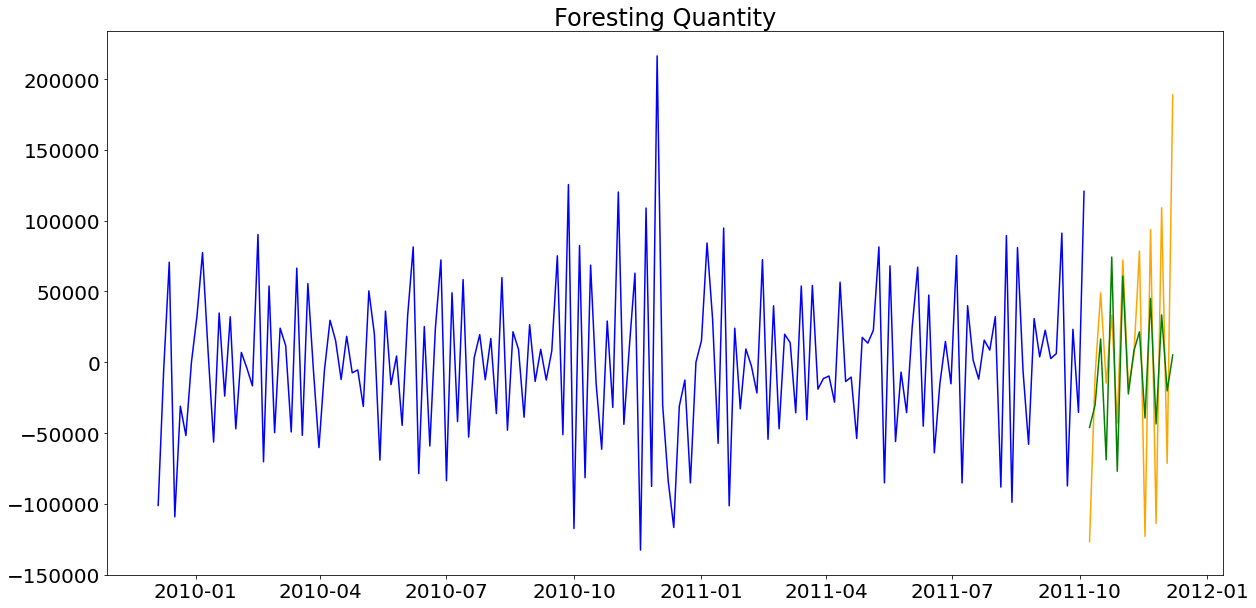

In [27]:
plot_results(x_test = test.index, x_train = train.index, y_training = train.values[:,0], y_testing = test.values[:,0], 
             predictions = ts_model.forecast(test.values, len(test))[:,0], title = "Foresting Quantity" )

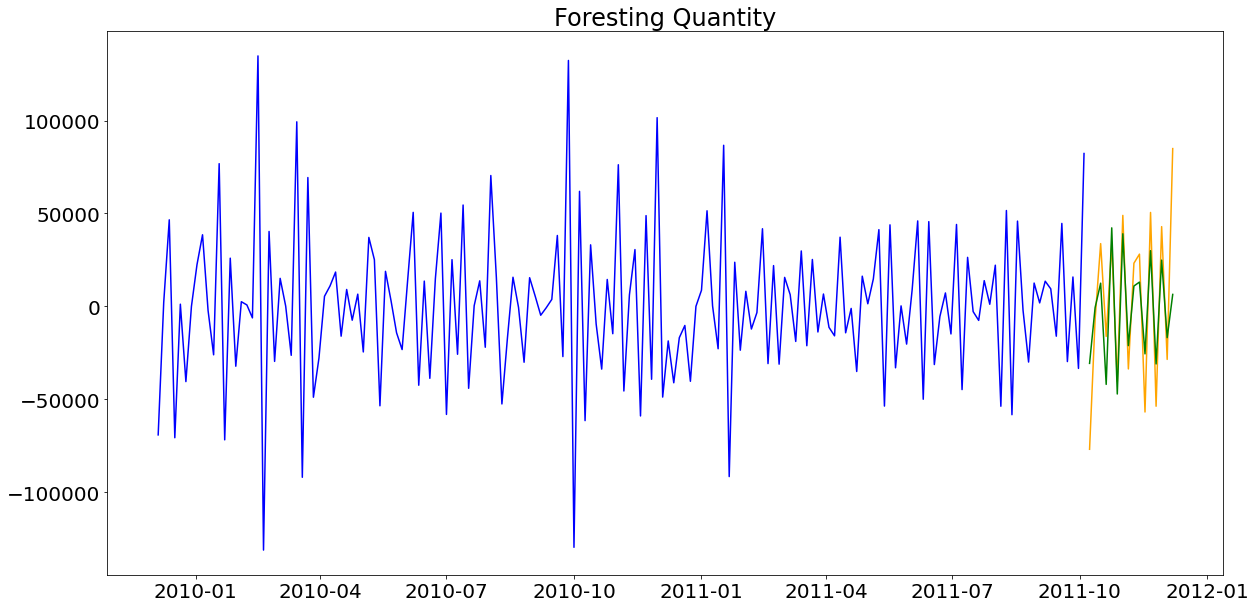

In [28]:
plot_results(x_test = test.index, x_train = train.index, y_training = train.values[:,1], y_testing = test.values[:,1], 
             predictions = ts_model.forecast(test.values, len(test))[:,1], title = "Foresting Quantity" )